In [1060]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import TruncatedSVD,NMF,LatentDirichletAllocation
import hazm
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from hazm import word_tokenize,Stemmer,Lemmatizer,POSTagger
from farsi_tools import stop_words,standardize_persian_text
from gensim.corpora import Dictionary
import gensim
from gensim.models import Word2Vec
from  PersianStemmer import PersianStemmer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from negar.virastar import PersianEditor
from symspellpy import SymSpell,Verbosity
from matplotlib import pyplot as plt
from nltk import FreqDist
pos_tag=POSTagger(model='pos_tagger.model')
per_stem=PersianStemmer()
stem=Stemmer()
lem=Lemmatizer()

In [1061]:
# add custom stopword with fasttest stopwords
with open('stopwords.txt',encoding="utf8") as f:
    stop=f.readlines()
# cleaning stopwords
stop_word=[word.replace('\n','') for word in stop]
stop_word=[re.sub('[\\u200c]',' ',word)  for word in stop_word]
stop_word.extend(stop_words())


# Reading  Data

In [1062]:
dataset=pd.read_csv('asriran.csv')[:1000]

In [1063]:
# echecking null values
dataset.isnull().sum()

title         0
shortlink     0
time          0
service       0
subgroup      0
abstract     70
body         62
dtype: int64

In [1064]:
# seprating uor data from dataset and conver to string
dataset=pd.DataFrame(dataset['body']).astype('string')
# removing junk value
dataset=dataset[dataset['body'].str.contains('<NA>')==False]
dataset.dropna()
dataset.reset_index(inplace=True,drop=True)

# Preprocessing
*1: extra word and symbol in text*
*2: tokenize data*
*3: tag words with hazm_tagger that based of StanfordPOSTagger*
*4: we need Nouns,split Noun_tags_words*
*5: lemmatize words with hazm_lemmatizer (finding root of words )*
*6: stemming word (removing extra data that words contain*
                                                  *7: removing word that has 1 character*
                                                                               *8: remover stopwords with farsi_tools stopwords*

In [1065]:
data=pd.Series(name='title')
# iterate in dataset (return col)
for i,r in dataset.iterrows():
    title=r['body']
    # removing English word
    text=re.sub('[A-Za-z]','',title)
    # removing digit
    text=re.sub(r'[\d+]','',text)
    # remove extra spaces
    text=re.sub('[ ]{1,}',' ',text)
    # remove punctuation and \u200c
    text = re.sub(r'[!@#$%^&*(),.?":{}|<>/«»،؛؟…_\-+\\\u200c]','', text)
    text=re.sub('[\xa0]','',text)
    # join word and ading to data
    data.loc[i]=''.join(text)

In [1066]:
# tokenize data
token=[word_tokenize(word) for word in data]

# remove stop words
token=[[word for word in words if word not in stop_word]for words in token]

# lematize
#token=[[lem.lemmatize(word) for word in words] for words in token]

# makgin n-grams
two_gram = gensim.models.Phrases(token, min_count=1, threshold=100)
tree_gram = gensim.models.Phrases(two_gram[token], threshold=100)
four_gram = gensim.models.Phrases(tree_gram[token], threshold=100)
five_gram= gensim.models.Phrases(four_gram[token], threshold=100)

# making n-gram models
two_gram_model= gensim.models.phrases.Phraser(two_gram)
tree_gram_model = gensim.models.phrases.Phraser(tree_gram)
four_gram_model = gensim.models.phrases.Phraser(five_gram)
five_gram_model = gensim.models.phrases.Phraser(five_gram)

#convert word with n-grams
token=[five_gram_model[four_gram_model[tree_gram_model[two_gram_model[word]]]] for word in token]

#pos_tag with hazm (NOUN,ADJ,VRB,...) for extracting features
token=[pos_tag.tag(word) for word in token]

# select 'NOUN,NOUN,EZ' words
taged_token=[]
for word in token:
    nouns=[]
    for word,por in word :
        if por=='NOUN':
            nouns.append(word)
        if por=='NOUN,EZ':
            nouns.append(word)
    taged_token.append(nouns)

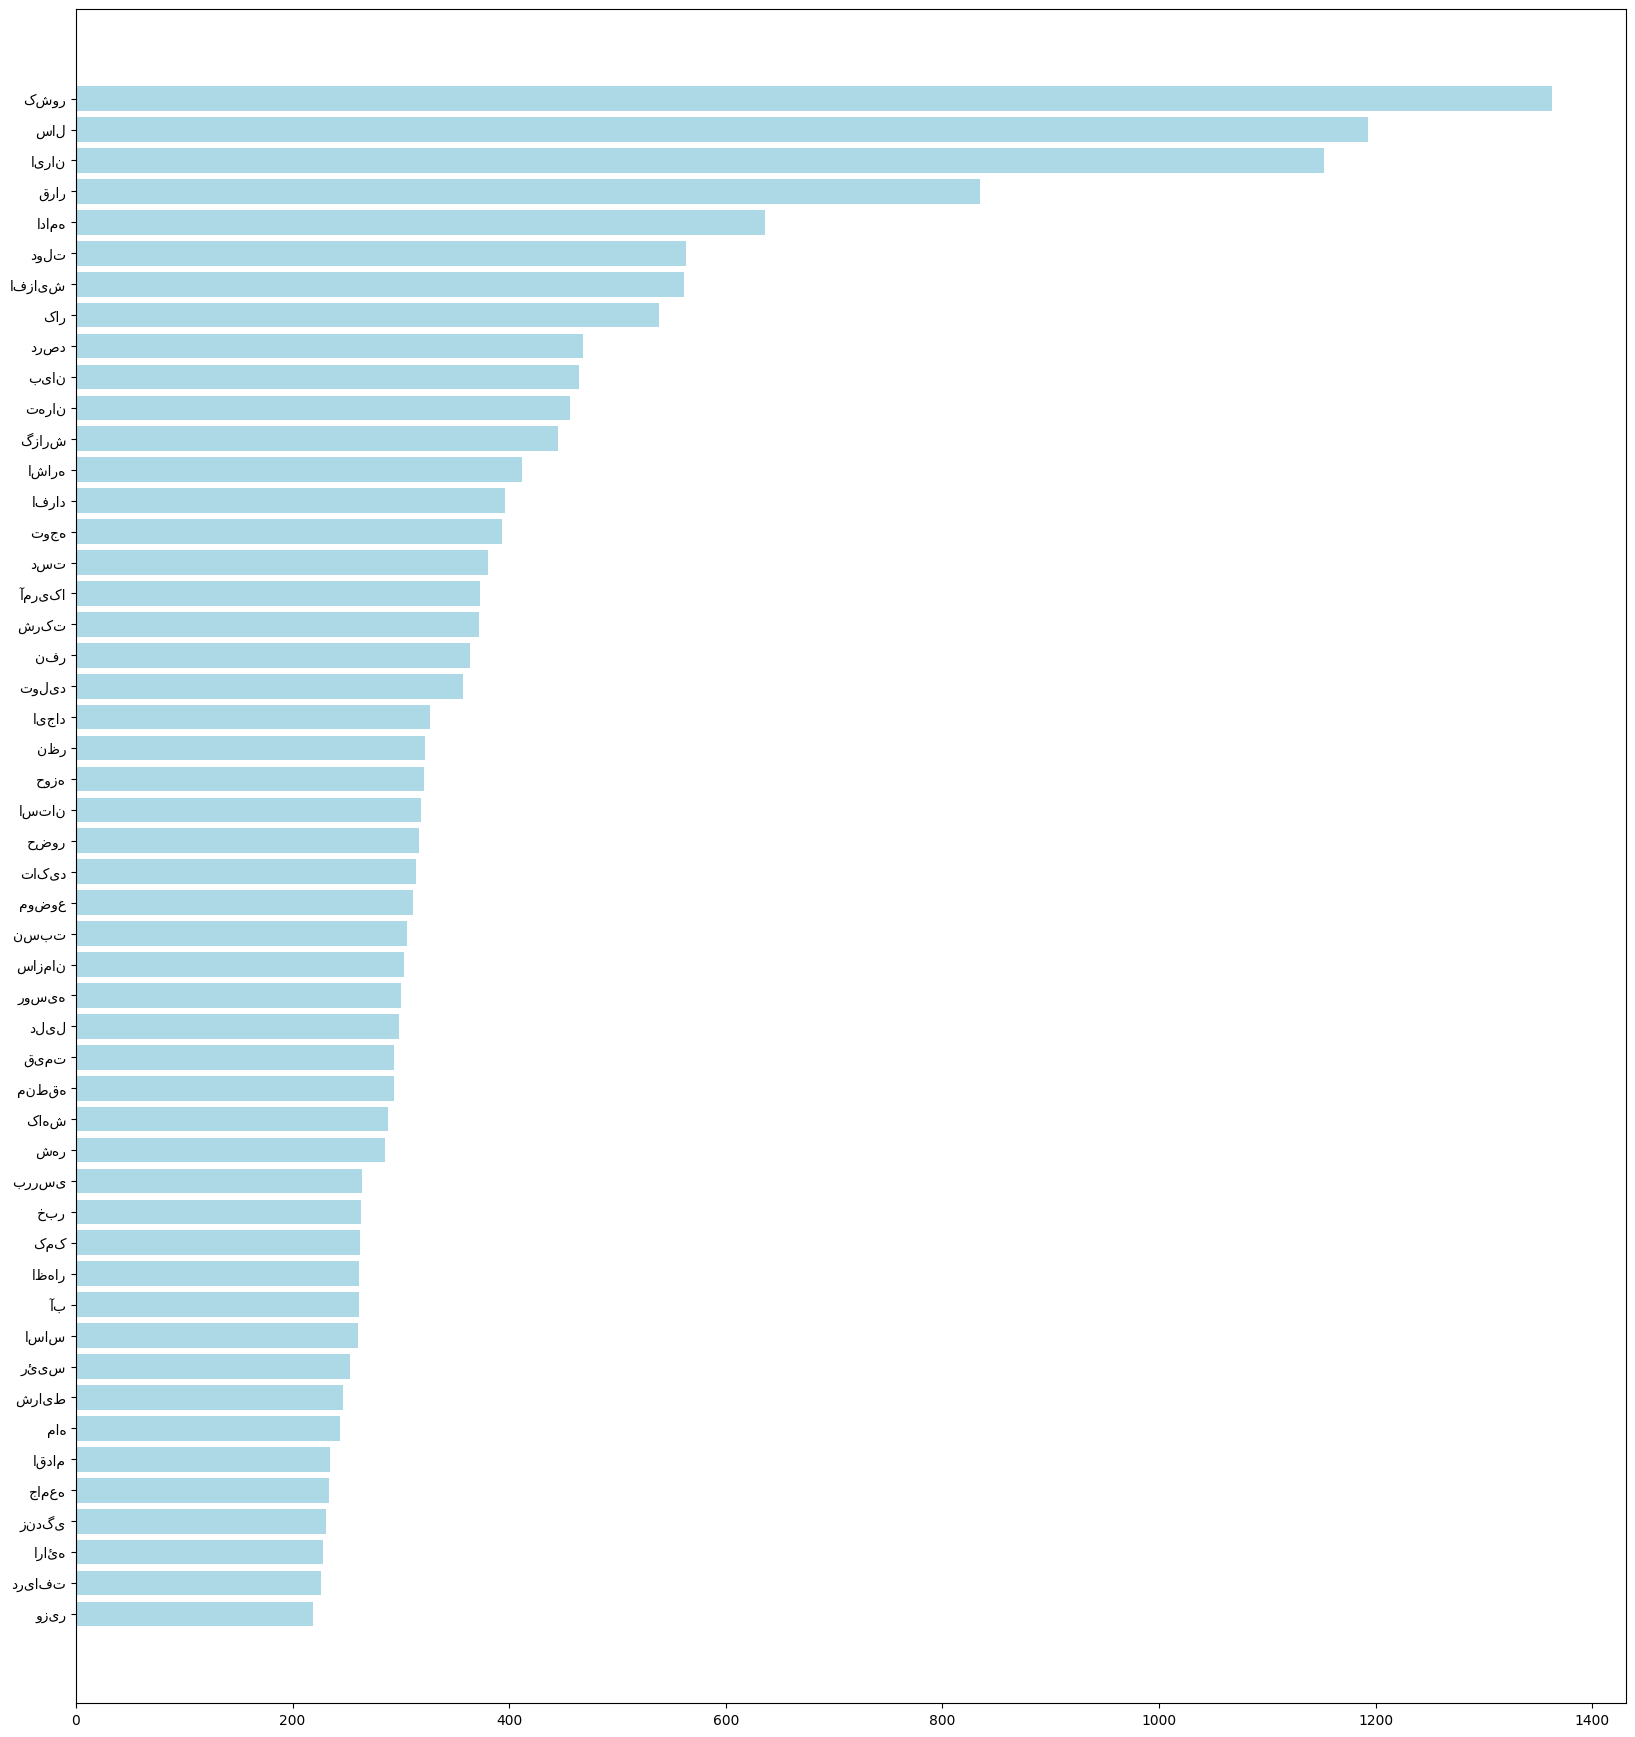

In [1067]:
#  commen word with FreqDist , it can be used for some stop words
com_word=FreqDist([word for words in taged_token for word in words]).most_common(50)
word_list = com_word[::-1]
# extracting comment words for ploting and stop words
fe_words,freq = [],[]
for word in word_list:
    fe_words.append(word[0])
    freq.append(word[1])
x=np.array(fe_words)
y=np.array(freq)

plt.figure(figsize=(20,22))
plt.barh(x,y,color="lightblue")
plt.show()

In [1068]:
# removeing most comment word
stop=fe_words[-20::-1]
final_cop=[]
for taged in taged_token:
    words=[]
    for word in taged:
        if word not in stop:
            words.append(word)
    final_cop.append(words)

#final_cop=taged_token

# make model with sklearn

In [1069]:
# usings  TF-IDF for making bag of words
tfidf_vec=TfidfVectorizer(ngram_range=(1,3),min_df=3,max_df=0.95)
# fiting ccorpus
tfidf_vec_fit=tfidf_vec.fit_transform([' '.join(word) for word in final_cop]).toarray()
#id to word
tfidf_vec_get_feature=tfidf_vec.get_feature_names_out()
print(tfidf_vec_get_feature)

['آئین' 'آب_جوش' 'آب_شور' ... 'یکشنبه' 'یکشنبه_تیر' 'یکشنبه_تیرماه']


In [1071]:
# NFM (sklearn)
#  reducing the number of features while retaining the basis information necessary to reconstruct the original data. Basically,
model_NFM=NMF( n_components=50,
               init='nndsvd',
               max_iter=100,
               l1_ratio=0.0,
               solver='mu',
               alpha_W=0.0,
               tol=1e-4,
               random_state=42)
model_NFM.fit(tfidf_vec_fit)



C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


NMF(init='nndsvd', max_iter=100, n_components=50, random_state=42, solver='mu')

In [1081]:
# merge genrated label with text
def topic_table(n_top_words, feature_names, nmf):
    topics = {}
    for i, topic_vec in enumerate(nmf.components_):
        topic_descr = ''
        for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_descr = topic_descr + feature_names[fid] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'top_topic': topics})

topic_df = topic_table(6, tfidf_vec_get_feature, model_NFM)
doc_vec = model_NFM.transform(tfidf_vec.transform([' '.join(word) for word in final_cop]))
dataset["topic_in"] = doc_vec.argmax(axis=1)
# Joining the original dataset with labels
df = pd.merge(dataset, topic_df, left_on='topic_in', right_index=True, how='left')
df


C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


,body,Topic_idx,topic_in,top_topic
0,رئیس پلیس آگاهی تهران بزرگ اعلام کرد که موضوع ...,5,2,پلیس سرقت کشف پرونده شناسایی متهم
1,"وزیر بهداشت جزییات طرح ""دارویار"" که اجرای آن آ...",5,33,واکسن کرونا دارو افزایش دوز واکسیناسیون
2,سخنگوی وزارت بهداشت، درمان و آموزش پزشکی در تو...,16,33,واکسن کرونا دارو افزایش دوز واکسیناسیون
3,معاون رئیس جمهور گفت: دولت برنامه های راهبردی ...,5,15,دولت افزایش مشکلات حقوق یارانه مصوبه
4,رییس پلیس فتا فرماندهی انتظامی گلستان گفت: سار...,5,2,پلیس سرقت کشف پرونده شناسایی متهم
...,...,...,...,...
933,ماموران پلیس پایتخت سارقی را که با استفاده از ...,5,2,پلیس سرقت کشف پرونده شناسایی متهم
934,نخست‌وزیر انگلیس امروز (چهارشنبه)، علیرغم استع...,5,18,جانسون انگلیس بوریس_جانسون استعفای استعفا دولت
935,سخنگوی شورای سیاستگذاری ائمه جمعه گفت: نماز عی...,3,44,نماز اصفهان استانداری_اصفهان اقامه_نماز معاون ...
936,رئیس دادگستری شهرستان بروجرد لرستان گفت: فردی ...,9,14,اورژانس حادثه نفر فوریتهای_پزشکی مرکز ساله


In [1073]:
#  Latent Dirichlet allocation (TruncatedSVD is LDA in sklearn )
# it based on Documents topic matrix and topic word matrix
model_LDA=LatentDirichletAllocation(n_components=25,
                                    learning_method='batch'
                                    ,random_state=42
                                    ,max_iter=200
                                    )
model_LDA.fit_transform(tfidf_vec_fit)

def topic_table(n_top_words, feature_names, nmf):
    topics = {}
    for i, topic_vec in enumerate(nmf.components_):
        topic_descr = ''
        for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_descr = topic_descr + feature_names[fid] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'top_topic': topics})

topic_df = topic_table(10, tfidf_vec_get_feature, model_LDA)
doc_vec = model_LDA.transform(tfidf_vec.transform([' '.join(word) for word in final_cop]))
dataset["Topic_idx"] = doc_vec.argmax(axis=1)

df = pd.merge(dataset, topic_df, left_on='Topic_idx', right_index=True, how='left')
df


,body,Topic_idx,Top_Topic_Terms
0,رئیس پلیس آگاهی تهران بزرگ اعلام کرد که موضوع ...,5,کشور ایران سال قرار تهران دولت افزایش ادامه در...
1,"وزیر بهداشت جزییات طرح ""دارویار"" که اجرای آن آ...",5,کشور ایران سال قرار تهران دولت افزایش ادامه در...
2,سخنگوی وزارت بهداشت، درمان و آموزش پزشکی در تو...,16,شهرستان شهرستان وضعیت وزارت_بهداشت اطلاع_رسانی...
3,معاون رئیس جمهور گفت: دولت برنامه های راهبردی ...,5,کشور ایران سال قرار تهران دولت افزایش ادامه در...
4,رییس پلیس فتا فرماندهی انتظامی گلستان گفت: سار...,5,کشور ایران سال قرار تهران دولت افزایش ادامه در...
...,...,...,...
933,ماموران پلیس پایتخت سارقی را که با استفاده از ...,5,کشور ایران سال قرار تهران دولت افزایش ادامه در...
934,نخست‌وزیر انگلیس امروز (چهارشنبه)، علیرغم استع...,5,کشور ایران سال قرار تهران دولت افزایش ادامه در...
935,سخنگوی شورای سیاستگذاری ائمه جمعه گفت: نماز عی...,3,تئاتر رنگ حقوق_بشر هنر هواپیما صندلی جیمز_وب ا...
936,رئیس دادگستری شهرستان بروجرد لرستان گفت: فردی ...,9,فارس برجام مسکن دادستان خط افغانستان تجارت پیش...




# LDA

In [1074]:
 # LDA with gensim
# make corpus to dic
dictionary=Dictionary(final_cop)
dictionary.filter_extremes(no_below=5,no_above=0.95)
# make bag of word with frequency and chane to numeric
co=[dictionary.doc2bow(word) for word in final_cop]
# LDA model
ld=gensim.models.ldamodel.LdaModel(    corpus=co,
                                       id2word=dictionary,
                                       num_topics=10,
                                       random_state=100,
                                       update_every=1,
                                       chunksize=10,
                                       passes=10,
                                       alpha='auto',
                                       iterations=100,
                                   )

print(ld.print_topics())

[(0, '0.056*"ایران" + 0.036*"کشور" + 0.024*"ادامه" + 0.023*"سال" + 0.020*"آمریکا" + 0.015*"جهان" + 0.013*"قرار" + 0.012*"کشورهای" + 0.011*"گزارش" + 0.011*"پایان"'), (1, '0.096*"دولت" + 0.022*"عراق" + 0.020*"ژاپن" + 0.019*"اسرائیل" + 0.016*"معرفی" + 0.016*"استاندار" + 0.014*"سخنرانی" + 0.014*"قتل" + 0.014*"هرمزگان" + 0.013*"مالیات"'), (2, '0.052*"بیان" + 0.033*"اشاره" + 0.020*"زمین" + 0.019*"شرکت" + 0.018*"تصریح" + 0.017*"پوشش" + 0.017*"زنان" + 0.017*"حجاب" + 0.016*"ادامه" + 0.016*"زن"'), (3, '0.040*"گزارش_ایرنا" + 0.035*"استعفا" + 0.034*"توافق" + 0.033*"پنجشنبه" + 0.031*"واکسن" + 0.029*"تصویب" + 0.027*"بوریس_جانسون" + 0.026*"سخنگوی" + 0.024*"مذاکرات" + 0.020*"اختصاص"'), (4, '0.023*"افراد" + 0.021*"بیماری" + 0.019*"انسان" + 0.016*"دانشگاه" + 0.015*"مصرف" + 0.015*"قرار" + 0.013*"رنگ" + 0.012*"بدن" + 0.011*"دوز" + 0.011*"فرد"'), (5, '0.046*"تهران" + 0.032*"خودرو" + 0.026*"پلیس" + 0.025*"کشف" + 0.024*"قرار" + 0.023*"انتقال" + 0.021*"پرونده" + 0.021*"تحقیقات" + 0.019*"جمعه" + 0.019*"همراه"'

In [1075]:
# measuring the degree of semantic similarity between high scoring words in the topic.
cor=gensim.models.CoherenceModel(model=ld,
                                 texts=final_cop,
                                 dictionary=dictionary,
                                 coherence='c_v')
cor.get_coherence()


0.33790703418243645

In [1076]:
topics_to_dataset=pd.DataFrame()
for i, j in enumerate(ld[co]):
    row=sorted(j,key=lambda x:(x[1]),reverse=True)
    for j,(top_n,top_val) in enumerate(row):
        if j==0 :
            wp=ld.show_topic(top_n)
            top_key=' '.join([word[0] for word in wp][:7])
            topics_to_dataset=topics_to_dataset._append(pd.Series([top_key]), ignore_index=True)
topics_to_dataset.columns = [ 'topic_key']
content=pd.Series(data)
topics_to_dataset=pd.concat([topics_to_dataset,content],axis=1)
topics_to_dataset.columns = ['topic_key', 'Text']
topics_to_dataset

,topic_key,Text
0,تهران خودرو پلیس کشف قرار انتقال پرونده,رئیس پلیس آگاهی تهران بزرگ اعلام کرد که موضوع ...
1,کشور نفر افزایش سال درصد پرداخت آغاز,وزیر بهداشت جزییات طرح دارویار که اجرای آن آغا...
2,افراد بیماری انسان دانشگاه مصرف قرار رنگ,سخنگوی وزارت بهداشت درمان و آموزش پزشکی در توئ...
3,ایران کشور ادامه سال آمریکا جهان قرار,معاون رئیس جمهور گفت دولت برنامه های راهبردی ا...
4,افراد بیماری انسان دانشگاه مصرف قرار رنگ,رییس پلیس فتا فرماندهی انتظامی گلستان گفت سارق...
...,...,...
933,تهران خودرو پلیس کشف قرار انتقال پرونده,ماموران پلیس پایتخت سارقی را که با استفاده از ...
934,گزارش_ایرنا استعفا توافق پنجشنبه واکسن تصویب ب...,نخستوزیر انگلیس امروز چهارشنبه علیرغم استعفای ...
935,فیلم هفته خانه دست خانواده محل عربستان,سخنگوی شورای سیاستگذاری ائمه جمعه گفت نماز عید...
936,فیلم هفته خانه دست خانواده محل عربستان,رئیس دادگستری شهرستان بروجرد لرستان گفت فردی ب...


In [1077]:
import pyLDAvis
from pyLDAvis import gensim_models
pyLDAvis.enable_notebook()
vis=gensim_models.prepare(ld,co,dictionary,mds='mmds',R=10)
vis

C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.408910  0.080831       1        1  19.378603
9     -0.022704  0.124695       2        1  12.653001
7     -0.260106  0.347735       3        1  12.169984
8      0.194399 -0.144462       4        1  11.841065
4      0.440402 -0.105763       5        1  11.836912
2      0.367689  0.248597       6        1   9.894925
5      0.084369  0.436278       7        1   6.874834
1      0.118687 -0.422715       8        1   6.714657
6     -0.327674 -0.178043       9        1   5.179131
3     -0.186152 -0.387153      10        1   3.456889, topic_info=              Term         Freq        Total Category  logprob  loglift
132          ایران   965.000000   965.000000  Default  10.0000  10.0000
90            دولت   575.000000   575.000000  Default   9.0000   9.0000
114           کشور  1446.000000  1446.000000  Default   8.0000   8.0000
188           بیان   460.000000   460.000000  Default   7.0000   7.0000
106            نفر   463.000000   463.000000  Default   6.0000   6.0000
...            ...          ...          ...      ...      ...      ...
1695         تصویب    90.434286    91.428901  Topic10  -3.5256   3.3539
2444  بوریس_جانسون    82.020521    83.025770  Topic10  -3.6232   3.3526
123         سخنگوی    79.804406    80.799360  Topic10  -3.6506   3.3524
1040       مذاکرات    73.572110    74.566324  Topic10  -3.7320   3.3514
1714        اختصاص    60.779733    61.774274  Topic10  -3.9230   3.3486

[139 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
62        2  0.996513         آغاز
280       1  0.998354       آمریکا
1714     10  0.987466       اختصاص
4         1  0.567769        ادامه
4         3  0.088412        ادامه
...     ...       ...          ...
419       1  0.992905      کشورهای
463       1  0.481803        گزارش
463       3  0.252135        گزارش
463       4  0.264617        گزارش
126      10  0.991257  گزارش_ایرنا

[162 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 8, 9, 5, 3, 6, 2, 7, 4])

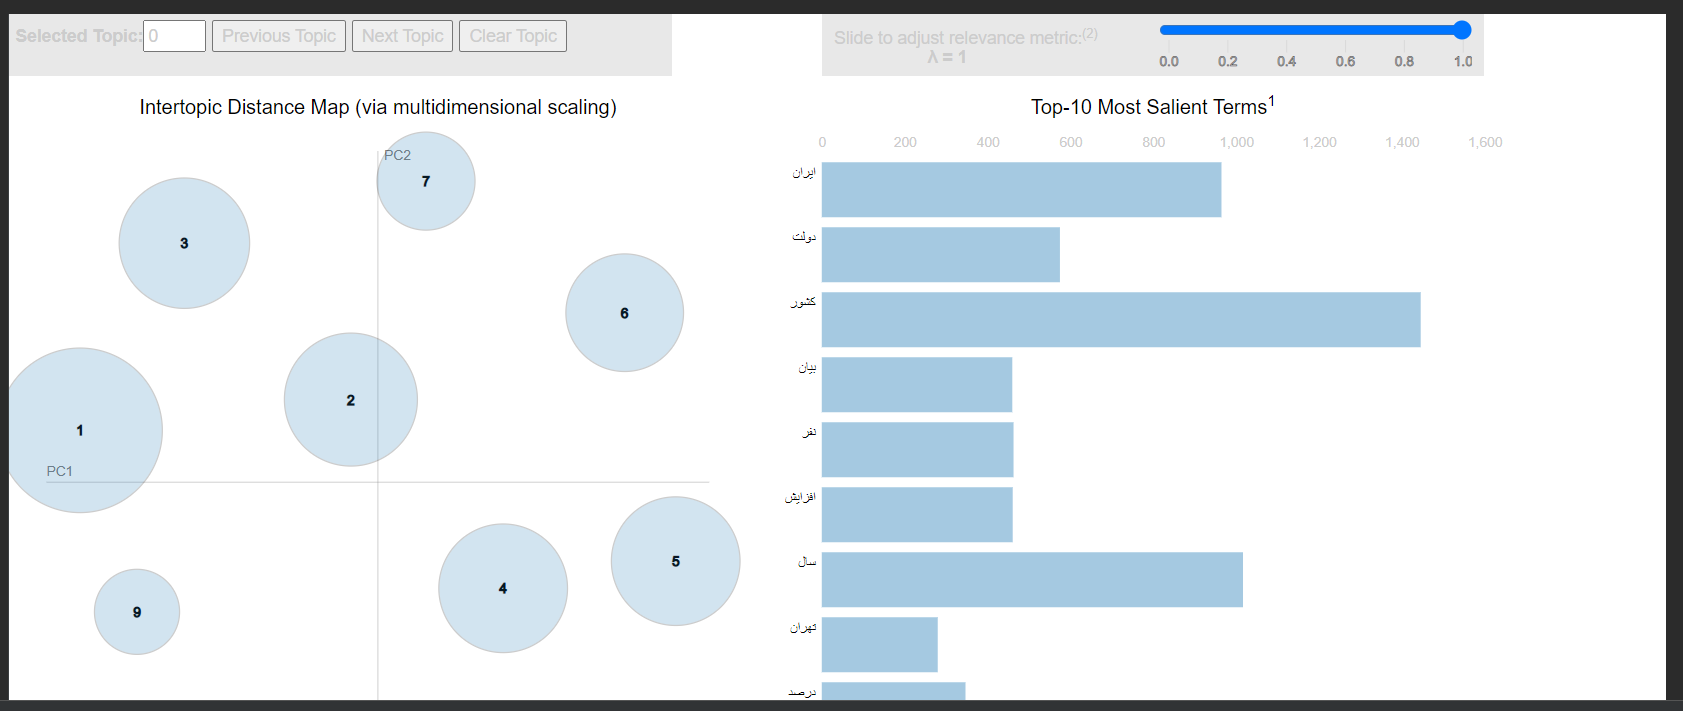

In [1082]:
from IPython import display
display.Image('img.png')

# NMF

In [1078]:
from gensim.models import Nmf
nmf = Nmf(
    corpus=co,
    num_topics=15,
    id2word=dictionary,
    chunksize=100,
    passes=5,
)


C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\gensim\models\nmf.py:578: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\gensim\models\nmf.py:607: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(co

In [1079]:
cor=gensim.models.CoherenceModel(model=nmf,
                                 texts=final_cop,
                                 dictionary=dictionary,
                                 coherence='c_v')
cor.get_coherence()

0.44943394671248593

In [1080]:
topics_to_dataset=pd.DataFrame()
for i, j in enumerate(nmf[co]):

    row=sorted(j,key=lambda x:(x[1]),reverse=True)

    for j,(top_n,top_val) in enumerate(row):
        if j==0 :
            wp=nmf.show_topic(top_n)
            top_key=' '.join([word[0] for word in wp][:5])
            topics_to_dataset=topics_to_dataset._append(pd.Series([ top_key]), ignore_index=True)
topics_to_dataset.columns = [ 'topic_key']
content=pd.Series(data)
topics_to_dataset=pd.concat([topics_to_dataset,content],axis=1)
topics_to_dataset.columns = ['topic_key', 'Text']
topics_to_dataset

,topic_key,Text
0,تهران گزارش دادستان شهرداری مرکز,رئیس پلیس آگاهی تهران بزرگ اعلام کرد که موضوع ...
1,افزایش بازار هفته توجه نرخ,وزیر بهداشت جزییات طرح دارویار که اجرای آن آغا...
2,بیماری بدن ویروس افراد درمان,سخنگوی وزارت بهداشت درمان و آموزش پزشکی در توئ...
3,دولت تومان مشکلات مسکن مصوبه,معاون رئیس جمهور گفت دولت برنامه های راهبردی ا...
4,تهران گزارش دادستان شهرداری مرکز,رییس پلیس فتا فرماندهی انتظامی گلستان گفت سارق...
...,...,...
933,بیان ادامه دشمن اشاره قرار,ماموران پلیس پایتخت سارقی را که با استفاده از ...
934,بیان ادامه دشمن اشاره قرار,نخستوزیر انگلیس امروز چهارشنبه علیرغم استعفای ...
935,NaN,سخنگوی شورای سیاستگذاری ائمه جمعه گفت نماز عید...
936,NaN,رئیس دادگستری شهرستان بروجرد لرستان گفت فردی ب...
